In [ ]:
import sys 
import os 
import numpy as np 

##### Signal

$$S(t) = I\cos(2 \pi f_c \times t) - Q\sin(2 \pi f_c \times t)$$

Минимальное расстояние между точками: $$d_{min} = \sqrt{2}$$

In [ ]:
def i_q_mapping(bin_level: int = 2) -> dict: 
    if (bin_level == 2): 
        return {
            "00": np.pi/4, 
            "01": 3*np.pi/4, 
            "10": 5*np.pi/4,
            "11": 7*np.pi/4 
        }
    else: 
        return {}

In [ ]:
import matplotlib.pyplot as plt


T = 10
t_line = np.linspace(0, 100, T*20)

def bits_to_ascii(bit_list):
    byte_strings = ["".join(map(str, bit_list[i:i+8])) for i in range(0, len(bit_list), 8)]

    ascii_string = "".join([chr(int(byte, 2)) for byte in byte_strings])
    
    return ascii_string

def ascii_to_bits(ascii_string):
    bit_list = []
    for char in ascii_string:
        bits = bin(ord(char))[2:].zfill(8)
        bit_list.extend(map(int, bits))
    
    return bit_list

# physical channel
#PCH = np.array() 

### Часть 1 QPSK I-Q mapping

Тут просто будут коды Грея

In [ ]:
def signal_forming(samples: np.array, modulation, oversampling=10) -> np.array:
    signal = []

    # Время одного символа
    t_symbol = np.linspace(0, T, oversampling, endpoint=False)
    
    if modulation == "qpsk":
        for i in range(0, len(samples)): 
            I = samples[i][0] 
            Q = samples[i][1] 

            s_t = I * np.cos(2 * np.pi * 1/T * t_symbol) - Q * np.sin(2 * np.pi * 1/T * t_symbol) 

            signal.extend(s_t)


    return np.array(signal) 


##### Формула поворота фаз 

$$I = \cos(\Theta_{in phase})$$
$$Q = \sin(\Theta_{quadrature})$$

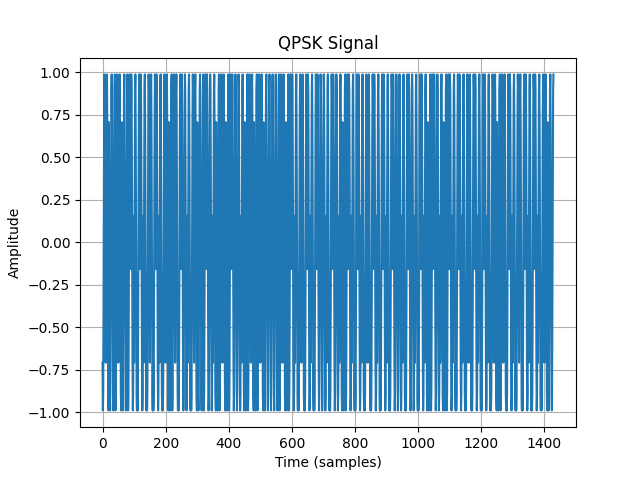

In [4]:
def i_q_qpsk_modulation(arr: np.array, bin_level: int = 2) -> np.array: 
    iq_map = i_q_mapping(bin_level)
    
    samples = []

    for i in range(0, len(arr) - 1): 
        first = arr[i]  
        second = arr[i+1]

        bits = f"{first}{second}"

        angle = iq_map[bits]; 
        
        I = np.cos(angle)
        Q = np.sin(angle)

        samples.append([I,Q]) 

    return np.array(samples, dtype=list)

test_data = np.array(ascii_to_bits("Dmitry Moskovskikh"), dtype=list)
i_q_data = i_q_qpsk_modulation(test_data)

signal = signal_forming(i_q_data, 'qpsk', oversampling=10) 

plt.plot(signal)
plt.title("QPSK Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

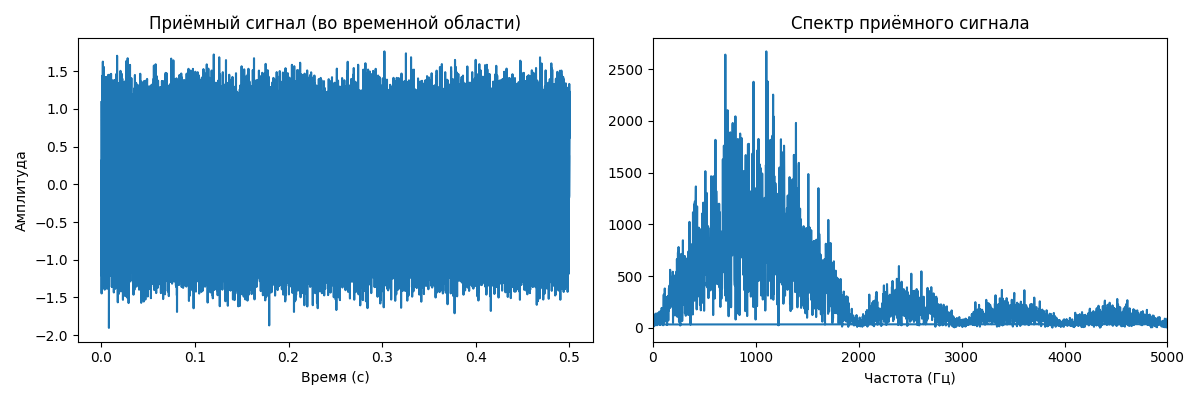

Исходная битовая последовательность (первые 40 бит): 0001011010100111011011001100110000100011
Демодулированная битовая последовательность (первые 40 бит): 0001011010100111011011001100110000100011


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для отображения битовой пары в фазу (QPSK с кодированием по Грею)
def i_q_mapping():
    return {
        "00": np.pi/4,
        "01": 3*np.pi/4,
        "11": 5*np.pi/4,
        "10": 7*np.pi/4
    }

# 1. Генерация случайной битовой последовательности
num_bits = 1000  # общее количество бит
bits = np.random.randint(0, 2, num_bits).astype(str)
bit_seq = "".join(bits)

# 2. Группировка битов по 2
bit_pairs = [bit_seq[i:i+2] for i in range(0, len(bit_seq), 2)]
# Если число бит нечетное, можно добавить дополнительный бит

# 3. Отображение битовых пар в фазы
mapping = i_q_mapping()
phases = [mapping[pair] for pair in bit_pairs if pair in mapping]

# 4. Параметры сигнала
A = 1.0                  # амплитуда
f_c = 1000               # частота несущей, Гц
T_sym = 1/f_c            # длительность символа, сек
fs = 100000              # частота дискретизации, Гц
t_sym = np.linspace(0, T_sym, int(fs * T_sym), endpoint=False)

# 5. Модуляция: для каждого символа генерируем отрезок сигнала
signal = np.array([])

for phi in phases:
    s = A * np.cos(2 * np.pi * f_c * t_sym + phi)
    signal = np.concatenate((signal, s))

# 6. Добавление шума (например, AWGN)
SNR_dB = 10  # отношение сигнал/шум в дБ
signal_power = np.mean(signal**2)
noise_power = signal_power / (10**(SNR_dB/10))
noise = np.sqrt(noise_power) * np.random.randn(len(signal))
rx_signal = signal + noise

# 7. Визуализация: пример временного сигнала и его спектра
t_total = np.linspace(0, T_sym * len(phases), len(rx_signal), endpoint=False)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(t_total, rx_signal)
plt.title("Приёмный сигнал (во временной области)")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")

plt.subplot(1, 2, 2)
# Вычисление спектра
fft_vals = np.fft.fft(rx_signal)
fft_freq = np.fft.fftfreq(len(rx_signal), d=1/fs)
plt.plot(fft_freq, np.abs(fft_vals))
plt.title("Спектр приёмного сигнала")
plt.xlabel("Частота (Гц)")
plt.xlim(0, 5000)
plt.tight_layout()
plt.show()

# 8. (Упрощённо) Демодуляция можно проводить, используя синхронный детектор.
# Для каждого символа выделяем соответствующий отрезок и вычисляем аргумент комплексного представления.
demod_bits = ""
for i in range(len(phases)):
    # Выделяем символ
    segment = rx_signal[i*len(t_sym):(i+1)*len(t_sym)]
    # Смешиваем с опорой (гипотетически известной несущей)
    ref_cos = np.cos(2*np.pi*f_c*t_sym)
    ref_sin = np.sin(2*np.pi*f_c*t_sym)
    I = 2 * np.mean(segment * ref_cos)  # ин-полярная составляющая
    Q = -2 * np.mean(segment * ref_sin) # квар- полярная (отрицательный знак зависит от выбранной сигнальной модели)
    phi_est = np.arctan2(Q, I)
    if phi_est < 0:
        phi_est += 2*np.pi  # переводим фазу в диапазон [0, 2pi)
    
    # Сравнение с идеальными фазами для определения битовой пары.
    # Здесь можно задать границы или найти ближайшую фазу.
    # Простой способ – вычислить разницу с каждой идеальной фазой.
    phase_diffs = {pair: np.abs(phi_est - mapping[pair]) for pair in mapping}
    demod_pair = min(phase_diffs, key=phase_diffs.get)
    demod_bits += demod_pair

# Сравнение исходной и демодулированной битовой последовательности
print("Исходная битовая последовательность (первые 40 бит):", bit_seq[:40])
print("Демодулированная битовая последовательность (первые 40 бит):", demod_bits[:40])


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
import ipywidgets as widgets
from IPython.display import display

# Функция генерации QPSK-сигнала
def generate_qpsk(num_symbols=100, Nsps=4, freq_offset=0, noise_level=0.1):
    bits = np.random.randint(0, 2, num_symbols * 2)  # Генерируем случайные биты
    symbols = (2 * bits[0::2] - 1) + 1j * (2 * bits[1::2] - 1)  # QPSK модуляция

    # Передискретизация (увеличение количества выборок на символ)
    signal = resample(symbols, num_symbols * Nsps)

    # Добавляем частотный сдвиг
    t = np.arange(len(signal))
    signal *= np.exp(1j * 2 * np.pi * freq_offset * t / len(signal))

    # Добавляем шум
    noise = (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal))) * noise_level
    return signal + noise

# Функция алгоритма Гарднера
def gardner_timing_recovery(signal, Nsps, damping=0.707, loop_bw=0.005):
    """ Алгоритм Гарднера для восстановления тактовой частоты """
    N = len(signal)
    mu = 0  # Начальный фазовый сдвиг
    out = np.zeros(N // Nsps, dtype=complex)
    err = np.zeros(N // Nsps)
    
    # Коэффициенты адаптации
    mi1 = (4 * damping * loop_bw) / (1 + 2 * damping * loop_bw + loop_bw ** 2)
    mi2 = (4 * loop_bw ** 2) / (1 + 2 * damping * loop_bw + loop_bw ** 2)

    phase = 0
    adap1 = 0
    adap2 = 0

    idx = 0
    for i in range(0, N - 2 * Nsps, Nsps):
        # Выборки по методу Гарднера
        x0 = signal[int(i + mu)]
        x1 = signal[int(i + Nsps / 2 + mu)]
        x2 = signal[int(i + Nsps + mu)]

        # Ошибка Гарднера
        error = (np.real(x2) - np.real(x0)) * np.real(x1) + (np.imag(x2) - np.imag(x0)) * np.imag(x1)
        err[idx] = error
        
        # Адаптивная подстройка тайминга
        adap2 += mi2 * error
        adap1 += adap2 + mi1 * error
        adap1 = np.clip(adap1, -1, 1)  # Ограничиваем в пределах [-1, 1]

        mu += adap1 * Nsps  # Коррекция тайминга
        
        # Сохраняем исправленные выборки
        out[idx] = x0
        idx += 1

    return out, err

# Визуализация работы алгоритма
def interactive_plot(num_symbols=100, Nsps=4, freq_offset=0, noise_level=0.1, damping=0.707, loop_bw=0.005):
    # Генерация QPSK-сигнала
    signal = generate_qpsk(num_symbols, Nsps, freq_offset, noise_level)
    
    # Восстановление тактовой частоты
    recovered, errors = gardner_timing_recovery(signal, Nsps, damping, loop_bw)
    
    # Графики
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    
    # Исходный сигнал
    axs[0, 0].plot(signal.real, signal.imag, 'b.', alpha=0.5)
    axs[0, 0].set_title("Созвездие (до коррекции)")
    axs[0, 0].grid()

    # Корректированный сигнал
    axs[0, 1].plot(recovered.real, recovered.imag, 'r.')
    axs[0, 1].set_title("Созвездие (после коррекции)")
    axs[0, 1].grid()

    # Ошибка синхронизации
    axs[1, 0].plot(errors, 'g')
    axs[1, 0].set_title("Ошибка Гарднера")
    axs[1, 0].grid()

    # Эволюция подстройки тайминга
    axs[1, 1].plot(np.arange(len(recovered)), np.angle(recovered), 'm')
    axs[1, 1].set_title("Фаза символов (после коррекции)")
    axs[1, 1].grid()

    plt.tight_layout()
    plt.show()

# Создаем интерактивные ползунки
widgets.interactive(interactive_plot,
                    num_symbols=widgets.IntSlider(min=2, max=500, step=50, value=100, description="Число символов"),
                    Nsps=widgets.IntSlider(min=2, max=8, step=1, value=4, description="Отсчетов на символ"),
                    freq_offset=widgets.FloatSlider(min=-0.1, max=0.1, step=0.01, value=0, description="Частотный сдвиг"),
                    noise_level=widgets.FloatSlider(min=0, max=0.5, step=0.01, value=0.1, description="Уровень шума"),
                    damping=widgets.FloatSlider(min=0.5, max=1.0, step=0.01, value=0.707, description="Демпфирование"),
                    loop_bw=widgets.FloatSlider(min=0.001, max=0.05, step=0.001, value=0.005, description="Полоса петли"))


interactive(children=(IntSlider(value=100, description='Число символов', max=500, min=2, step=50), IntSlider(v…